In [6]:
import matplotlib.pyplot as plt
import numpy as np

### Load data from pickled files

In [11]:
import pickle

run_nr=9999999
number_of_parallel_runs=24

results = {}
for no in range(number_of_parallel_runs):
    path = "output/benchmark/{run_nr}/results_{no}.pickle".format(run_nr=run_nr,no=no)
    try:
        with open(path, 'rb') as handle:
            results = {**results,**pickle.load(handle)}
    except:
        print("Error!")
        pass
        
print(len(results))

6752


### Helper functions

In [116]:
from collections import defaultdict
 
def extract_by_graph(results):
    graph_dict= defaultdict(list)
    
    graph_prefixes = [
        "geom_graph",
        "householdsuper",
        "erdos_renyi",
        "barabasi",
        "grid_2d",
        "newman",
        "complete",
        "regular"
    ]
    
    for result_item in results.items():
        ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) = result_item
        for prefix in graph_prefixes:
            if graph_name.startswith(prefix):
                graph_dict[prefix].append(result_item)
                continue
    
    return graph_dict

def extract_by_baseline(results):
    baseline_dict= defaultdict(list)
    
    for result_item in results.items():
        ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) = result_item
        baseline_dict[baseline_name].append(result_item)
    
    return baseline_dict

# Information about the graphs

#### Num nodes vs num edges

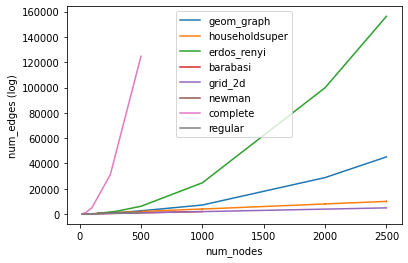

In [117]:
graph_dict = extract_by_graph(results)
import numpy as np
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    data = [(g["num_nodes"],g["num_edges"]) for g in graph_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data), label=graph_prefix)
    
plt.legend()
plt.xlabel('num_nodes')
plt.ylabel('num_edges (log)')
#plt.yscale('log')
plt.show()

#### graph type to properties

Mean degree for geom_graph:18.045011111111116
Mean degree for householdsuper:7.901179583333334
Mean degree for erdos_renyi:53.52847777777777
Mean degree for barabasi:3.904827586206897
Mean degree for grid_2d:3.796666666666667
Mean degree for newman:6.0
Mean degree for regular:5.0


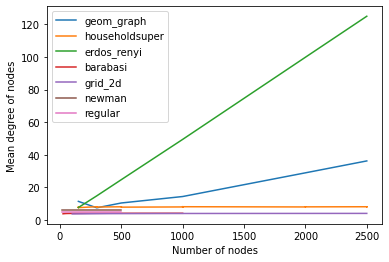

In [118]:
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    if graph_prefix == "complete":
        continue
    print(f'Mean degree for {graph_prefix}:{np.mean([g["degree_mean"] for g in graph_data_list])}')
    data = [(g["num_nodes"],g["degree_mean"]) for g in graph_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data), label=graph_prefix)
    
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Mean degree of nodes')
plt.show()

Average shortest path length for geom_graph:8.288081283503129
Average shortest path length for householdsuper:3.1697320739131114
Average shortest path length for erdos_renyi:2.211344033139334
Average shortest path length for barabasi:3.240380977966431
Average shortest path length for grid_2d:18.333333333333336
Average shortest path length for newman:3.3349603872085005
Average shortest path length for complete:1.0
Average shortest path length for regular:3.124021732315619


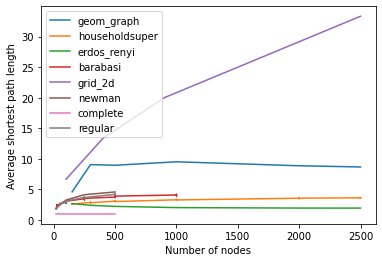

In [119]:
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    print(f'Average shortest path length for {graph_prefix}:{np.mean([g["average_shortest_path_length"] for g in graph_data_list])}')
    data = [(g["num_nodes"],g["average_shortest_path_length"]) for g in graph_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*data), label=graph_prefix)
    
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Average shortest path length')
plt.show()

In [120]:
for (graph_prefix, result_item_list) in graph_dict.items():
    graph_data_list = [ri[1][0] for ri in result_item_list]
    print(f'Mean average clustering for {graph_prefix}:{np.mean([g["average_clustering"] for g in graph_data_list])}')

Mean average clustering for geom_graph:0.6234024537851625
Mean average clustering for householdsuper:0.10803306942132315
Mean average clustering for erdos_renyi:0.05019139809343546
Mean average clustering for barabasi:0.11476880123167767
Mean average clustering for grid_2d:0.0
Mean average clustering for newman:0.3427033730158732
Mean average clustering for complete:1.0
Mean average clustering for regular:0.05439140625000002


# Information about the baselines

In [124]:
baseline_dict = extract_by_baseline(results)

## Information about the baselines: Speed

#### Number of nodes vs duration

Average duration for baseline davaFast: 39.78434533219767
Average duration for baseline betweenness: 14.028676754772945
Average duration for baseline closeness: 2.647017008037929
Average duration for baseline PersPageRank: 0.589301711010142
Average duration for baseline PageRank: 0.5339173038988881
Average duration for baseline EVcentrality: 0.20503967011709348
Average duration for baseline degree: 0.13030489135127496
Average duration for baseline random: 0.12728489010254918


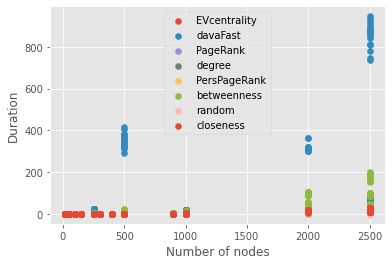

In [163]:
plt.style.use('ggplot')
avg_durations = {}
for (baseline_name, result_item_list) in baseline_dict.items():
    result_data_list = [ri[1] for ri in result_item_list]
    
    avg_durations[baseline_name] = np.mean([r["duration"] for g,r in result_data_list])
    
    data = [(g["num_nodes"],r["duration"]) for g,r in result_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.scatter(*zip(*data), label=baseline_name)
  

avg_durations = dict(sorted(avg_durations.items(),key=lambda x: x[1], reverse=True))
for bn_bame, avg_dur in avg_durations.items():
    print(f'Average duration for baseline {bn_bame}: {avg_dur}')
    
    
    
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Duration')
plt.show()

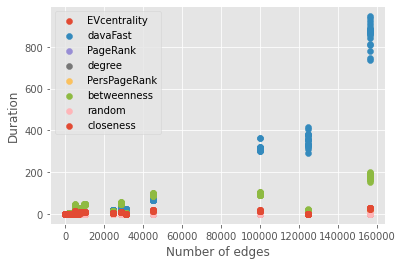

In [164]:
plt.style.use('ggplot')
for (baseline_name, result_item_list) in baseline_dict.items():
    result_data_list = [ri[1] for ri in result_item_list]
    data = [(g["num_edges"],r["duration"]) for g,r in result_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.scatter(*zip(*data), label=baseline_name)
    
plt.legend()
plt.xlabel('Number of edges')
plt.ylabel('Duration')
plt.show()

## Information about the baselines: Performance

#### Mean score

In [205]:
extracted_means = {}
for (baseline_name, result_item_list) in baseline_dict.items():
    scores = [ri[1][1]["score_mean"] for ri in result_item_list]
    extracted_means[baseline_name] = np.mean(scores)

extracted_means = sorted(extracted_means.items(),key=lambda x: x[1], reverse=True)

for name, mean_score in extracted_means:
    print(name,":\t", mean_score)

davaFast :	 0.1180797351171669
PersPageRank :	 0.10619990006582412
PageRank :	 0.0880021809110058
degree :	 0.08242700109268036
betweenness :	 0.08191362789626119
closeness :	 0.06531565527251185
EVcentrality :	 0.06202725421274355
random :	 0.03295394277909426


#### Mean ratio score/duration

In [206]:
extracted_ratios = {}
for (baseline_name, result_item_list) in baseline_dict.items():
    result_data_list = [ri[1] for ri in result_item_list]
    
    extracted_ratios[baseline_name]= np.mean([r["score_mean"]/r["duration"] for g,r in result_data_list])

extracted_ratios = sorted(extracted_ratios.items(),key=lambda x: x[1], reverse=True)
for name, mean_ratio in extracted_ratios:
    print(name,"-\t", mean_ratio)

degree -	 30.641014787561204
random -	 14.537957889624645
EVcentrality -	 14.26162573313617
davaFast -	 10.728774650951843
closeness -	 8.83065555040737
PersPageRank -	 4.975582841060914
betweenness -	 4.438917934047361
PageRank -	 4.2170350945475334


#### Infection rate vs. random score

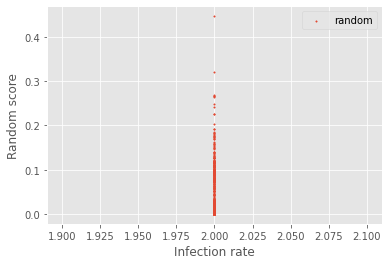

In [226]:
plt.style.use('ggplot')
for (baseline_name, result_item_list) in baseline_dict.items():
    if baseline_name != 'random':
        continue
    data = [(inf_rate, result_data["score_mean"]) for ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) in result_item_list]
    
    #data = [(g["num_edges"],r["duration"]) for g,r in result_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.scatter(*zip(*data), label=baseline_name, s=2)
    
plt.legend()
plt.xlabel('Infection rate')
plt.ylabel('Random score')
plt.show()

#### budget/infected vs. score

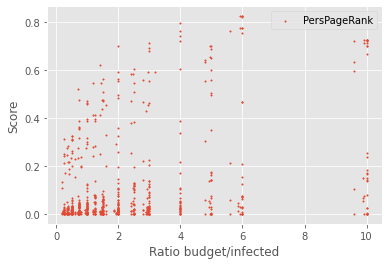

In [227]:
plt.style.use('ggplot')
for (baseline_name, result_item_list) in baseline_dict.items():
    if baseline_name != 'PersPageRank':
        continue
    data = [(float(budget/(infected_fraction*graph_data["num_nodes"])), result_data["score_mean"]) for ((inf_rate,graph_name, baseline_name,infected_fraction,budget),(graph_data,result_data)) in result_item_list]
    
    #data = [(g["num_edges"],r["duration"]) for g,r in result_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data]
    
    data.sort(key=lambda x:x[0])
    
    plt.scatter(*zip(*data), label=baseline_name, s=2)
    
plt.legend()
plt.xlabel('Ratio budget/infected')
plt.ylabel('Score')
plt.show()

#### density vs score

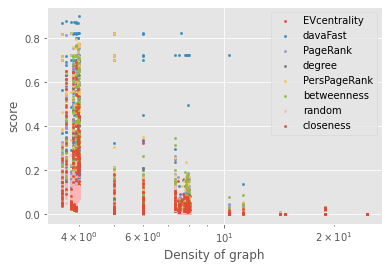

In [228]:
for (baseline_name, result_item_list) in baseline_dict.items():
    #if baseline_name != "random":
     #   continue
    result_data_list = [ri[1] for ri in result_item_list]
    data = [(g["degree_mean"],r["score_mean"]) for g,r in result_data_list]
    data = list(set(data)) #remove duplicates
    data = [(x,y) for x,y in data if x<=25]
    
    data.sort(key=lambda x:x[0])
    
    plt.scatter(*zip(*data), label=baseline_name,s=5)
    
plt.legend()
plt.xlabel('Density of graph')
plt.ylabel('score')
plt.xscale('log')
plt.show()